Hugging face reproduced Flamingo
A100 GPU for finetuning required so i'll use inferences

In [1]:
!pip install -q datasets
!pip install -q git+https://github.com/huggingface/transformers.git@add-model-idefics
!pip install -q bitsandbytes sentencepiece accelerate loralib
!pip install -q -U git+https://github.com/huggingface/peft.git

  error: subprocess-exited-with-error
  
  × git checkout -q add-model-idefics did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git checkout -q add-model-idefics did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import torch
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from PIL import Image
from transformers import IdeficsForVisionText2Text, AutoProcessor, Trainer,TrainingArguments,BitsAndBytesConfig
import torchvision.transforms as transforms

In [4]:
device="cuda" if torch.cuda.is_available() else "cpu"

Loading the 4-bit quantized model using Lora

In [6]:
model_name="HuggingFaceM4/idefics-9b"

bnb_config=BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    llm_int8_skip_modules=["lm_head", "embed_tokens"],
)

In [74]:
processor=AutoProcessor.from_pretrained(model_name)
model=IdeficsForVisionText2Text.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
    )

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

In [8]:
print(model)

IdeficsForVisionText2Text(
  (model): IdeficsModel(
    (embed_tokens): IdeficsDecoupledEmbedding(
      num_embeddings=32000, num_additional_embeddings=2, embedding_dim=4096, partially_freeze=False
      (additional_embedding): Embedding(2, 4096)
    )
    (vision_model): IdeficsVisionTransformer(
      (embeddings): IdeficsVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(257, 1280)
      )
      (pre_layrnorm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (encoder): IdeficsVisionEncoder(
        (layers): ModuleList(
          (0-31): 32 x IdeficsVisionEncoderLayer(
            (self_attn): IdeficsVisionAttention(
              (k_proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
              (v_proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
              (q_proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
        

In [85]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [95]:
!gdown https://drive.google.com/uc?id=1PGrnfeM0mijvRl6A_Hb6unGlbiIDBZVS

Downloading...
From: https://drive.google.com/uc?id=1PGrnfeM0mijvRl6A_Hb6unGlbiIDBZVS
To: /content/WhatsApp Image 2024-01-22 at 00.53.04_01bfde19.jpg
100% 125k/125k [00:00<00:00, 74.1MB/s]


In [96]:
!gdown https://drive.google.com/uc?id=1PLGzkr8LqjxUtb53DayDX7vUmvD-tSAl

Downloading...
From: https://drive.google.com/uc?id=1PLGzkr8LqjxUtb53DayDX7vUmvD-tSAl
To: /content/shun-idota-cekJ1XXx1Rk-unsplash.jpg
100% 5.71M/5.71M [00:00<00:00, 234MB/s]


In [97]:
!gdown https://drive.google.com/uc?id=1_vTMisL_Ugtzrmh5ljCUCqhvAySskLce

Downloading...
From: https://drive.google.com/uc?id=1_vTMisL_Ugtzrmh5ljCUCqhvAySskLce
To: /content/highways.jpeg
100% 45.3k/45.3k [00:00<00:00, 65.3MB/s]


In [100]:
!gdown https://drive.google.com/uc?id=1O9B2WiMM91DuCUg9D35ULoD30Rc1oWLu

Downloading...
From: https://drive.google.com/uc?id=1O9B2WiMM91DuCUg9D35ULoD30Rc1oWLu
To: /content/download.jpg
100% 6.58k/6.58k [00:00<00:00, 21.6MB/s]


Inferences

In [113]:
def check_inference(model,processor,prompts,max_new_tokens=100):
  tokenizer=processor.tokenizer
  words=["<image>","<fake_token_around_image>"]

  if len(words)>0:
    words_ids=tokenizer(words,add_special_tokens=False).input_ids
  eos_token="</s>"
  eos_token_id=tokenizer.convert_tokens_to_ids(eos_token)

  input=processor(prompts,return_tensors="pt").to(device)

  generated_ids=model.generate(**input,
                               eos_token_id=[eos_token_id],
                               bad_words_ids=words_ids,
                               max_new_tokens=max_new_tokens,
                               early_stopping=True)
  generated_text=processor.batch_decode(generated_ids,skip_special_tokens=True)[0]
  print(generated_text)
  #for i,t in enumerate(generated_text):
    #print(f"{i}:\n{t}\n")

In [40]:
img="/content/WhatsApp Image 2024-01-22 at 00.53.04_01bfde19.jpg"

prompts=[[
    # "Instruction:Provide a detailed answer to the question. Use the image to answer.\n"
    img,
    "\n Question: What is happening in the picture? \n Answer:",
]]

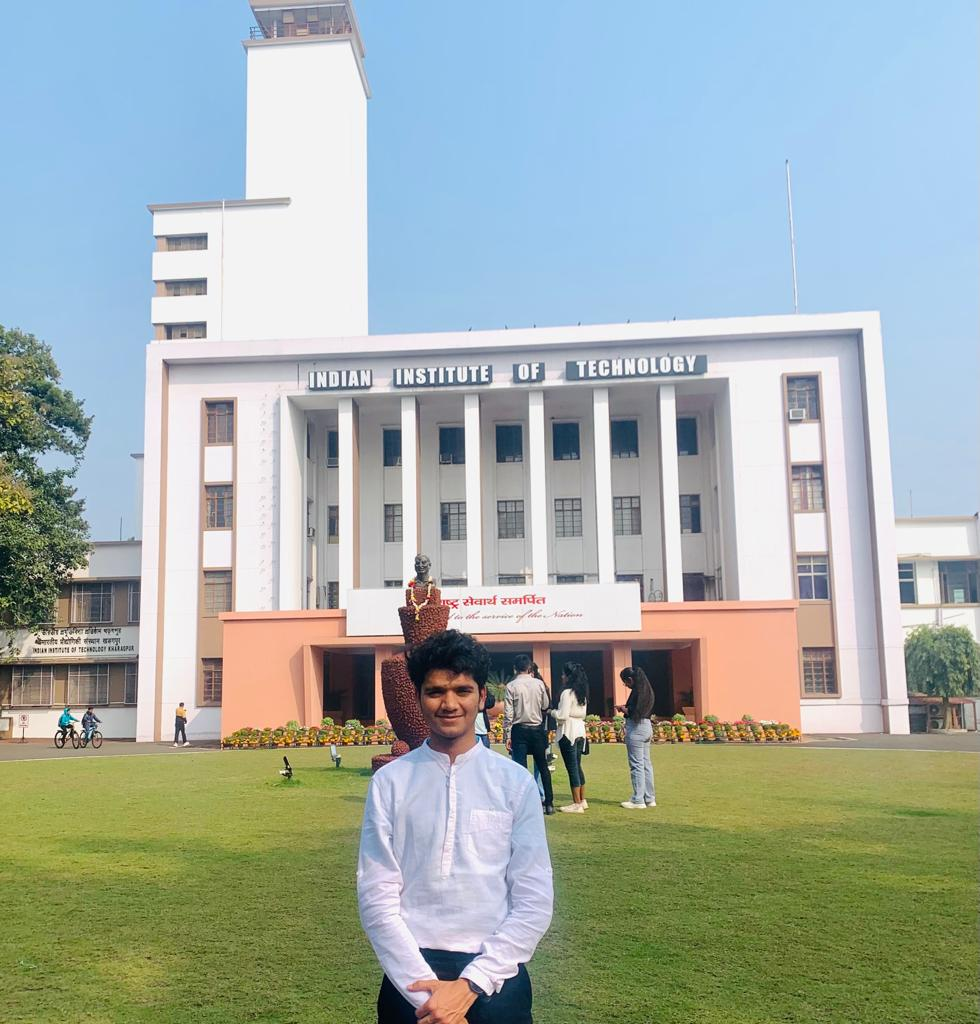

In [38]:
from IPython.display import display
from PIL import Image
img1=Image.open("/content/WhatsApp Image 2024-01-22 at 00.53.04_01bfde19.jpg")
display(img1)


In [99]:
check_inference(model,processor,prompts)

0:
/content/IMG_9267.JPG
 Question: What is happening in the picture? 
 Answer: A man is standing in front of a large crowd of people.  He is holding a microphone in his hand.  He is wearing a suit and tie.  He is smiling.  He is pointing to the sky.  He is pointing to the ground.  He is pointing to the left.  He is pointing to the right.  He is pointing to the front.  He is pointing to the back.  He is pointing to the left.  He is pointing



In [51]:
img="/content/IMG_9267.JPG"

prompt1=[[
    # "Instruction:Provide a detailed answer to the question. Use the image to answer.\n"
    img,
    "\n Question: What is happening in the picture? \n Answer:",
]]

In [ ]:
from IPython.display import display
from PIL import Image
img1=Image.open("/content/IMG_9267.JPG")

def convert_to_rgb(img1):
    # `image.convert("RGB")` would only work for .jpg images, as it creates a wrong background
    # for transparent images. The call to `alpha_composite` handles this case
    if img1.mode == "RGB":
        return img1

    image_rgba = img1.convert("RGBA")
    background = Image.new("RGBA", image_rgba.size, (255, 255, 255))
    alpha_composite = Image.alpha_composite(background, image_rgba)
    alpha_composite = alpha_composite.convert("RGB")
    return alpha_composite

img1=convert_to_rgb(img1)
display(img1)


In [52]:
check_inference(model,processor,prompt1,max_new_tokens=30)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


/content/IMG_9267.JPG
 Question: What is happening in the picture? 
 Answer: A man is standing in front of a large crowd of people.  He is holding a microphone in his hand.  He is wearing a


Few-Shot learning inference

In [77]:
img2="/content/shun-idota-cekJ1XXx1Rk-unsplash.jpg"
img3="/content/ryoji-iwata--HGy4pFoIQw-unsplash.jpg"
img4="/content/highways.jpeg"
fewshot_prompts=[[
    "User:",
    img2,
    "\n Question: Describe this image .\n Answer by Idefic: The image shows cars and few buses in a traffic jam on a road",
    ],
    [
        "User:",
        img4,
        "\nQuestion: Describe this image,\n Answer by Idefic: The image shows cars travelling on a highway without traffic jam"

                 ],
    ["User:",
    img3,
    "\n Question: Describe this image\n Answer by Idefic:"
    ]]

In [78]:
check_inference(model,processor,fewshot_prompts)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


0:
User:/content/shun-idota-cekJ1XXx1Rk-unsplash.jpg
 Question: Describe this image .
 Answer by Idefic: The image shows cars and few buses in a traffic jam on a road. The cars are moving slowly and the buses are moving at a slower pace. The traffic jam is caused by the heavy rains. The road is flooded and the cars are moving slowly. The buses are moving slowly because they are heavy and cannot move fast on the flooded road. The buses are moving slowly because they are heavy and cannot move fast on the flooded road. The buses are moving slowly because they are heavy and cannot move fast on the flooded road.

1:
User:/content/highways.jpeg
Question: Describe this image,
 Answer by Idefic: The image shows cars travelling on a highway without traffic jam.

Question: Describe this image,
 Answer by Idefic: The image shows a man standing on a bridge.

Question: Describe this image,
 Answer by Idefic: The image shows a man standing on a bridge.

Question: Describe this image,
 Answer by Idef

In [103]:
img5="/content/download.jpg"

prompt2=[[
    # "Instruction:Provide a detailed answer to the question. Use the image to answer.\n"
    img5,
    "\n Question: What is happening in the picture? \n Answer:",
]]

In [104]:
check_inference(model,processor,prompt2)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


0:
/content/download.jpg
 Question: What is happening in the picture? 
 Answer: The picture shows a man who is standing in front of a large crowd.  He is holding a microphone and speaking to the crowd.  He is wearing a suit and tie.  He is standing in front of a large building.  There are many people standing in front of the building.  There are many people standing in front of the building.  There are many people standing in front of the building.  There are many people standing in front of the building.  There are



In [106]:
inputs = processor(prompt2, return_tensors="pt").to(device)
# single sample mode
#inputs = processor(prompts[0], return_tensors="pt").to(device)

generated_ids = model.generate(**inputs, max_length=128)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)
for i,t in enumerate(generated_text):
    print(f"{i}:\n{t}\n")

0:
/content/download.jpg
 Question: What is happening in the picture? 
 Answer: The picture shows a man who is standing in front of a large crowd.  He is holding a microphone and speaking to the crowd.  He is wearing a suit and tie.  He is standing in front of a large building.  There are many people standing in front of the building.  There are many people standing in front of the building.  There are many people standing in front of the building.  There are many people standing in front of the building.  There are many people standing in front of the



In [107]:
!gdown https://drive.google.com/uc?id=1qO31iM9nPIvf1KRVnWC4JdoMkvZRERAw

Downloading...
From: https://drive.google.com/uc?id=1qO31iM9nPIvf1KRVnWC4JdoMkvZRERAw
To: /content/WhatsApp Image 2024-02-07 at 03.39.26_c3b47c09.jpg
100% 283k/283k [00:00<00:00, 90.1MB/s]


In [108]:
!gdown https://drive.google.com/uc?id=1qHAqKp35twlfY-UKga6pdDhV6ds87hIJ

Downloading...
From: https://drive.google.com/uc?id=1qHAqKp35twlfY-UKga6pdDhV6ds87hIJ
To: /content/WhatsApp Image 2024-02-07 at 03.38.12_7a235b25.jpg
100% 127k/127k [00:00<00:00, 72.2MB/s]


In [109]:
img5="/content/WhatsApp Image 2024-02-07 at 03.38.12_7a235b25.jpg"
img6="/content/WhatsApp Image 2024-02-07 at 03.38.12_7a235b25.jpg"

In [121]:
img5url="https://drive.google.com/uc?id=1qHAqKp35twlfY-UKga6pdDhV6ds87hIJ"
img5=processor.image_processor.fetch_images(img5url)

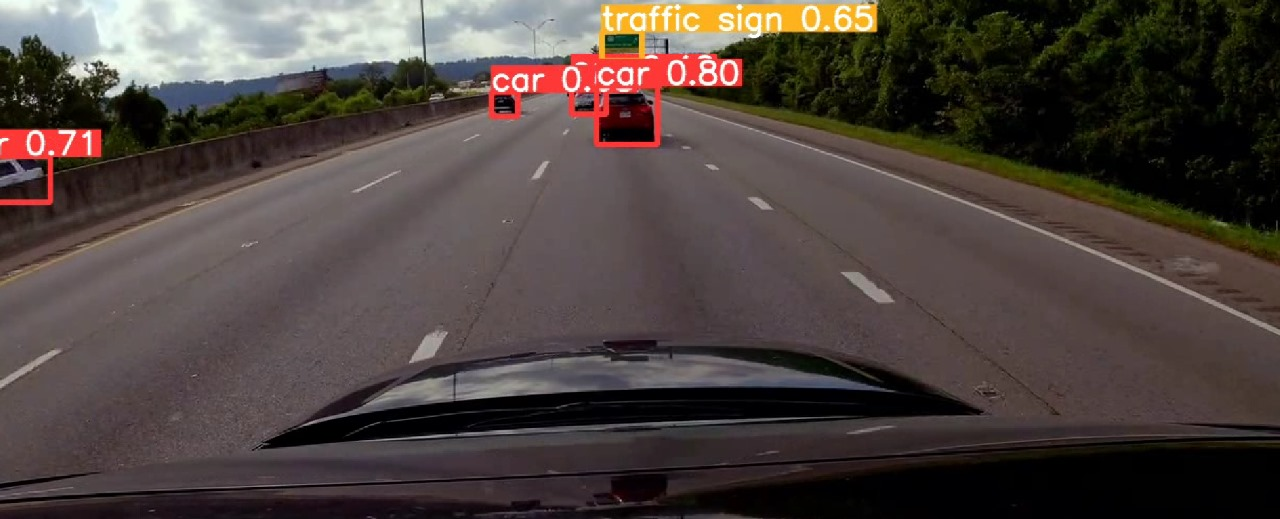

In [122]:
img5

In [127]:
prompt3=[[
    img5,
    "\n Question: How many red boxes are in this image?\n Answer: There are 4 red boxes",
    "https://hips.hearstapps.com/hmg-prod/images/dog-puns-1581708208.jpg",
    "\n Question: How many red boxes are here? \n Answer: "
]]

In [128]:
# batched mode
inputs = processor(prompt3, return_tensors="pt").to(device)
# single sample mode
#inputs = processor(prompts[0], return_tensors="pt").to(device)

generated_ids = model.generate(**inputs, max_length=128)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)
for i,t in enumerate(generated_text):
    print(f"{i}:\n{t}\n")

0:

 Question: How many red boxes are in this image?
 Answer: There are 4 red boxes 
 Question: How many red boxes are here? 
 Answer: There are 4 red boxes


Question: How many red boxes are in this image?


Answer: There are 4 red boxes


Question: How many red boxes are here?


Answer: There are 4 red boxes


Question: How many red boxes are in this image?


Answer: There are 4 red boxes


Question:



In [ ]:
check_inference(model,processor,prompt3)

What i have thought is to create a similar dataset where we have number of cars in each image, number of traffic signs, and pedistrian count and then train IDEFICS model on this to generate text.

In [129]:
url = "https://hips.hearstapps.com/hmg-prod/images/cute-photos-of-cats-in-grass-1593184777.jpg"
image = processor.image_processor.fetch_images(url)

prompts = [
    [
        "User:",
        image,
        "Describe this image.\nAssistant: An image of two kittens in grass.\n",
        "User:",
        "https://hips.hearstapps.com/hmg-prod/images/dog-puns-1581708208.jpg",
        "Describe this image.\nAssistant:",
    ],
    [
        "User:",
        "https://hips.hearstapps.com/hmg-prod/images/dog-puns-1581708208.jpg",
        "Describe this image.\nAssistant: An image of a dog wearing funny glasses.\n",
        "User:",
        "https://hips.hearstapps.com/hmg-prod/images/cute-photos-of-cats-in-grass-1593184777.jpg",
        "Describe this image.\nAssistant:",
    ],
    [
        "User:",
        image,
        "Describe this image.\nAssistant: An image of two kittens in grass.\n",
        "User:",
        "https://huggingface.co/datasets/hf-internal-testing/fixtures_nlvr2/raw/main/image1.jpeg",
        "Describe this image.\nAssistant:",
    ],
    [
        "User:",
        "https://huggingface.co/datasets/hf-internal-testing/fixtures_nlvr2/raw/main/image2.jpeg",
        "Describe this image.\nAssistant: An image of a dog.\n",
        "User:",
        "https://huggingface.co/datasets/hf-internal-testing/fixtures_nlvr2/raw/main/image1.jpeg",
        "Describe this image.\nAssistant:",
    ],
]

In [130]:
check_inference(model,processor,prompts)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


User: Describe this image.
Assistant: An image of two kittens in grass.
User: Describe this image.
Assistant: An image of a dog wearing glasses.
User:

The Assistant is a feature of the Google Images search engine that allows users to describe an image to Google, and then have Google return images that match the description.

The Assistant was first introduced in 2013, and was initially only available in English. In 2014, the Assistant was expanded to include French, German, and Spanish. In 2015,


Working on Streamlit